In [462]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import flopy
from flopy.utils.gridintersect import GridIntersect

In [463]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [464]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


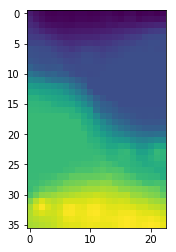

In [465]:
# layer 0 thickness
def getdz0():
    fname = './data/gwt_lak_top.dat'
    dz0 = np.loadtxt(fname)
    dz0 = dz0.reshape((36, 23))
    return dz0
plt.imshow(getdz0())

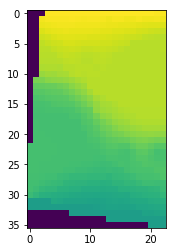

In [466]:
# starting head
def getstrt():
    fname = './data/gwt_lak_strt.dat'
    strt = np.loadtxt(fname)
    return strt
plt.imshow(getstrt())

In [467]:
def get_chdlist(modelgrid):
    chdlist = []
    from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
    delr = 4.05665E02
    delc = 4.03717E02
    nrow = 36
    ncol = 23
    
    # middle nodes
    ls = LineString([[11*delr, nrow*delc], [15*delr, nrow*delc]])
    ix = GridIntersect(gwf.modelgrid)
    ra = ix.intersect_linestring(ls)
    chdlist += [[(0, i, j), 50.15] for i, j in list(ra['cellids'])]

    # outer two nodes on each side
    ls = MultiLineString([[[9*delr, nrow*delc], [11*delr, nrow*delc]], 
                    [[15*delr, nrow*delc], [17*delr, nrow*delc]]])
    ix = GridIntersect(gwf.modelgrid)
    ra = ix.intersect_linestring(ls)
    chdlist += [[(0, i, j), 50.10] for i, j in list(ra['cellids'])]
    
    # middle set of nodes on each side
    ls = MultiLineString([[[3*delr, nrow*delc], [9*delr, nrow*delc]], 
                    [[17*delr, nrow*delc], [21*delr, nrow*delc]]])
    ix = GridIntersect(gwf.modelgrid)
    ra = ix.intersect_linestring(ls)
    chdlist += [[(0, i, j), 50.] for i, j in list(ra['cellids'])]
    return chdlist

def get_chdlist():
    fname = './data/gwt_lak_ibd.dat'
    ibd = np.loadtxt(fname)
    chdlist = []
    for k in range(8):
        rowlist, collist = np.where(ibd == -1)
        chdlist += [[(k, i, j), 50.] for i, j in zip(rowlist, collist)]
        rowlist, collist = np.where(ibd == -2)
        chdlist += [[(k, i, j), 50.15] for i, j in zip(rowlist, collist)]
        rowlist, collist = np.where(ibd == -3)
        chdlist += [[(k, i, j), 50.1] for i, j in zip(rowlist, collist)]
        rowlist, collist = np.where(ibd == -4)
        chdlist += [[(k, i, j), 28.] for i, j in zip(rowlist, collist)]
    return chdlist
get_chdlist()

[[(0, 0, 3), 50.0],
 [(0, 0, 4), 50.0],
 [(0, 0, 5), 50.0],
 [(0, 0, 6), 50.0],
 [(0, 0, 7), 50.0],
 [(0, 0, 8), 50.0],
 [(0, 0, 17), 50.0],
 [(0, 0, 18), 50.0],
 [(0, 0, 19), 50.0],
 [(0, 0, 20), 50.0],
 [(0, 0, 11), 50.15],
 [(0, 0, 12), 50.15],
 [(0, 0, 13), 50.15],
 [(0, 0, 14), 50.15],
 [(0, 0, 9), 50.1],
 [(0, 0, 10), 50.1],
 [(0, 0, 15), 50.1],
 [(0, 0, 16), 50.1],
 [(0, 32, 0), 28.0],
 [(0, 32, 1), 28.0],
 [(0, 32, 2), 28.0],
 [(0, 32, 3), 28.0],
 [(0, 32, 4), 28.0],
 [(0, 32, 5), 28.0],
 [(0, 32, 6), 28.0],
 [(0, 32, 7), 28.0],
 [(0, 33, 7), 28.0],
 [(0, 33, 8), 28.0],
 [(0, 33, 9), 28.0],
 [(0, 33, 10), 28.0],
 [(0, 33, 11), 28.0],
 [(0, 33, 12), 28.0],
 [(0, 33, 13), 28.0],
 [(0, 34, 13), 28.0],
 [(0, 34, 14), 28.0],
 [(0, 34, 15), 28.0],
 [(0, 34, 16), 28.0],
 [(0, 34, 17), 28.0],
 [(0, 34, 18), 28.0],
 [(0, 34, 19), 28.0],
 [(0, 34, 20), 28.0],
 [(0, 35, 20), 28.0],
 [(0, 35, 21), 28.0],
 [(0, 35, 22), 28.0],
 [(1, 0, 3), 50.0],
 [(1, 0, 4), 50.0],
 [(1, 0, 5), 50.0],
 [(1

In [468]:
# <lakeno> <iconn> <cellid(ncelldim)> <claktype> <bedleak> <belev> <telev> <connlen> <connwidth>
def ibd2lak(ibd, lakids=[2, 3]):
    delr = 4.05665E02
    delc = 4.03717E02
    pd = []
    cd = []
    nlay, nrow, ncol = ibd.shape
    stagestrt = [44.7, 35.2]
    for ilak, l in enumerate(lakids):
        ncon = 0
        icon = 0
        for k, i, j in zip(*np.where(ibd == l)):
            # make vertical connection to an active cell below that is not a lake
            if k < nlay - 1:
                if ibd[k + 1, i, j] not in [0] + lakids:
                    ncon += 1
                    cd.append([ilak, icon, (k + 1, i, j), 'vertical', 10., -999., -999., -999., -999.])
                    icon += 1
            # make horizontal connection to an active cell to the back
            if i > 0:
                if ibd[k, i - 1, j] not in [0] + lakids:
                    ncon += 1
                    cd.append([ilak, icon, (k, i - 1, j), 'horizontal', 10., -999., -999., delc/2., delr])
                    icon += 1
            # make horizontal connection to an active cell to the left
            if j > 0:
                if ibd[k, i, j - 1] not in [0] + lakids:
                    ncon += 1
                    cd.append([ilak, icon, (k, i, j - 1), 'horizontal', 10., -999., -999., delr/2., delc])
                    icon += 1
            # make horizontal connection to an active cell to the right
            if j < ncol - 1:
                if ibd[k, i, j + 1] not in [0] + lakids:
                    ncon += 1
                    cd.append([ilak, icon, (k, i, j + 1), 'horizontal', 10., -999., -999., delr/2., delc])
                    icon += 1
            # make horizontal connection to an active cell to the front
            if i < nrow - 1:
                if ibd[k, i + 1, j] not in [0] + lakids:
                    ncon += 1
                    cd.append([ilak, icon, (k, i + 1, j), 'horizontal', 10., -999., -999., delc/2., delr])
                    icon += 1
        pd.append([ilak, stagestrt[ilak], ncon])
    return pd, cd
    
def get_lakdata():
    fname = './data/gwt_lak_ibd.dat'
    ibd0 = np.loadtxt(fname, dtype=np.int)
    nrow, ncol = ibd0.shape
    ibd2 = np.where(ibd0 > 1, 1, ibd0)
    
    ibd0 = ibd0.reshape((1, nrow, ncol))
    ibd2 = ibd2.reshape((1, nrow, ncol))
    ibd = np.vstack((ibd0, ibd2))
    pd, cd = ibd2lak(ibd)
    return pd, cd

pd, cd = get_lakdata()

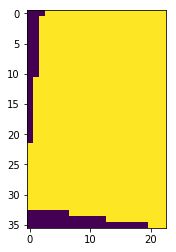

In [469]:
def get_idomain():
    fname = './data/gwt_lak_ibd.dat'
    ibd = np.loadtxt(fname)
    ibd0 = np.where(ibd > 1, 0, ibd)
    ibd0 = np.where(ibd0 != 0, 1, 0)
    ibd2 = np.where(ibd > 1, 1, ibd)
    ibd2 = np.where(ibd2 != 0, 1, 0)
    return [ibd0] + 7 * [ibd2]
plt.imshow(get_idomain()[2])

In [495]:
def get_model(ws, name, nlay=8, nrow=36, ncol=23,
              single_matrix=False, hhformulation=True,
              constant_concentration=False, general_head_boundary=False,
              ctimes=None, cidx=None, sptimes=None, verbosity_level=1):
    
    # model units are in cm/min

    lx = 23 * 4.05665E02
    ly = 36 * 4.03717E02

    delr = lx / ncol
    delc = ly / nrow
    top = 100.
    botm = []
    tp = top * np.ones((nrow, ncol), dtype=np.float)
    for k in range(0, nlay):
        dz = 15.
        if k == 0:
            dz = getdz0()
        bt = tp - dz
        botm.append(tp - dz)
        tp = bt
        
    perlen = [25 * 365.] # time is in days
    nper = len(perlen)
    nstp = [100]
    tsmult = [1.]
    steady = True
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

    # This should be changed to one true and one false after scott fixes
    # flopy.
    nouter, ninner = 10000, 10
    hclose, rclose, relax = 1e-4, 1., 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    sim.name_file.continue_ = True
    
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name

    gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=gwfname,
                            model_nam_file='{}.nam'.format(gwfname))

    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwfname))
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    idomain = get_idomain()
    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,
                                  idomain=idomain)
    
    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=nlay*[getstrt()])

    # node property flow
    hk = 250. # ft/d
    vk = 125.
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  #cvoptions=[('VARIABLECV')],
                                  icelltype=[1, 1] + 6 * [0],
                                  k=hk, k33=vk)

    chdlist_temp = get_chdlist()
    chdlist = []
    for cid, hd in chdlist_temp:
        k, i, j = cid
        conc = 0.
        if k in [0, 1] and i == 0 and j in [11, 12, 13, 14]:
            conc = 500.
        chdlist.append([cid, hd, conc])
    chd1 = flopy.mf6.ModflowGwfchd(gwf,
                                   stress_period_data=chdlist,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   auxiliary=('CONCENTRATION'),
                                   pname='CHD')    

    recharge = 4.79e-3
    rch = flopy.mf6.ModflowGwfrcha(gwf,
                                   recharge=recharge)
    
    packagedata, connectiondata = get_lakdata()
    lakeperioddata = [(0, 'rainfall', 0.), (1, 'rainfall', 0.)]
    lak = flopy.mf6.ModflowGwflak(gwf,
                                  pname='LAK-1',
                                  save_flows=True,
                                  print_flows=True,
                                  print_input=True,
                                  print_stage=True,
                                  stage_filerecord=gwfname + '.lak.bin',
                                  nlakes=len(packagedata),
                                  packagedata=packagedata,
                                  connectiondata=connectiondata,
                                  lakeperioddata=lakeperioddata)

    # output control
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 23, 'WIDTH', 15,
                                     'DIGITS', 5, 'GENERAL')],
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        nouter, ninner = 50, 10
        hclose, rclose, relax = 1e-4, 1., 0.97
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL', no_ptcrecord=[('ALL')]
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm, idomain=idomain)

    # initial conditions
    strt = 0.
    ic = flopy.mf6.ModflowGwtic(gwt, strt=strt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

    # dispersion
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=True, diffc=1.e-8,
                                  alh=20., ath1=2., atv=0.2)

    # mass storage and transfer
    porosity = 0.3
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)

    # sources
    sourcerecarray = [('CHD', 'AUX', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    
    lktpackagedata = [(0, 0., 99., 999., 'mylake1'), 
                      (1, 0., 99., 999., 'mylake2')]
    lkt = flopy.mf6.modflow.ModflowGwtlkt(gwt,
                                          boundnames=True,
                                          save_flows=True,
                                          print_input=True,
                                          print_flows=True,
                                          print_concentration=True,
                                          concentration_filerecord=gwtname + '.lkt.bin',
                                          budget_filerecord='gwtlak1.bud',
                                          nlakes=2,
                                          packagedata=lktpackagedata,
                                          pname='LAK-1',
                                          auxiliary=['aux1', 'aux2'])
    # output control
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 23, 'WIDTH', 15,
                                     'DIGITS', 5, 'GENERAL')],
                                saverecord=[('CONCENTRATION', 'ALL')],
                                printrecord=[('CONCENTRATION', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))


    
    sim.write_simulation()
    v = sim.run_simulation(report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
        
    result_dict = {}
    result_dict['sim'] = sim
    result_dict['gwf'] = gwf
    result_dict['gwt'] = gwt
    
    fname = gwfname + '.hds'
    fname = os.path.join(ws, fname)
    hobj = flopy.utils.HeadFile(fname, precision='double')
    head = hobj.get_data()
    hobj.file.close()
    result_dict['head'] = head

    fname = gwfname + '.lak.bin'
    fname = os.path.join(ws, fname)
    hobj = flopy.utils.HeadFile(fname, precision='double', text='stage')
    stage = hobj.get_data()
    hobj.file.close()
    result_dict['stage'] = stage

    fname = gwtname + '.ucn'
    fname = os.path.join(ws, fname)
    cobj = flopy.utils.HeadFile(fname, precision='double', text='concentration')
    conc = cobj.get_data()
    cobj.file.close()
    result_dict['conc'] = conc

    fname = gwtname + '.lkt.bin'
    fname = os.path.join(ws, fname)
    cobj = flopy.utils.HeadFile(fname, precision='double', text='concentration')
    conc = cobj.get_alldata()
    times = cobj.get_times()
    cobj.file.close()
    result_dict['clak'] = conc
    result_dict['claktimes'] = times
    
    return result_dict

ws = './temp/pxx_gwt_lak'
name = 'gwtlak'
result_dict = get_model(ws, name)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package gwtlak.gwfgwt...
  writing model gwf_gwtlak...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 352 based on size of stress_period_data
    writing package rcha...
    writing package lak-1...
    writing package oc...
  writing model gwt_gwtlak...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package lak-1...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                

In [486]:
head = result_dict['head']
stage = result_dict['stage']
conc = result_dict['conc']
clak = result_dict['clak'][-1]

fname = './data/gwt_lak_ibd.dat'
ibd = np.loadtxt(fname)

# push lake stages into headstage and clak into concclak
headstage = head.copy()
concclak = conc.copy()

rows, columns = np.where(ibd == 2)
for i, j in zip(rows, columns):
    headstage[0, i, j] = stage[0, 0, 0]
    headstage[1, i, j] = stage[0, 0, 0]
    concclak[0, i, j] = clak[0, 0, 0]
    concclak[1, i, j] = clak[0, 0, 0]
    
rows, columns = np.where(ibd == 3)
for i, j in zip(rows, columns):
    headstage[0, i, j] = stage[0, 0, 1]
    headstage[0, i, j] = stage[0, 0, 1]
    concclak[0, i, j] = clak[0, 0, 1]
    concclak[0, i, j] = clak[0, 0, 1]

In [487]:
def get_colored_patch_collection(modelgrid, ibd, ibdval, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for i in range(modelgrid.nrow):
        for j in range(modelgrid.ncol):
            if ibd[i, j] == ibdval:
                x0 = xv[i, j]
                x1 = xv[i, j + 1]
                y0 = yv[i, j]
                y1 = yv[i + 1, j]
                poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
                #print(poly)
                patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
                patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True)
    return pc

In [488]:
def plot_lakes(ax):
    pc0 = get_colored_patch_collection(gwf.modelgrid, ibd, 0, ec='none', fc='black')
    pcl1 = get_colored_patch_collection(gwf.modelgrid, ibd, 2, ec='none', fc='gray')
    pcl2 = get_colored_patch_collection(gwf.modelgrid, ibd, 3, ec='none', fc='gray')
    ax.add_collection(pc0)
    ax.add_collection(pcl1)
    ax.add_collection(pcl2)
    return

<a list of 5 text.Text objects>

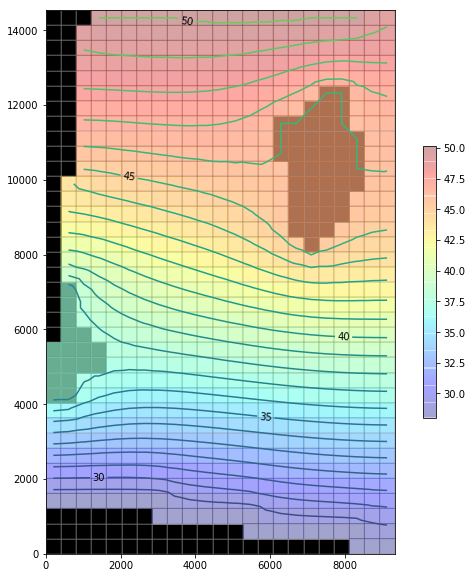

In [489]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=0)
pmv.plot_grid(alpha=0.3)
cb = pmv.plot_array(headstage, masked_values=[1.e30], cmap='jet', alpha=0.2)
cs = pmv.contour_array(headstage, masked_values=[1.e30], levels=np.arange(20, 60))
fname = './data/gwt_lak_ibd.dat'
ibd = np.loadtxt(fname)
plot_lakes(ax)
plt.colorbar(cb, shrink=0.5)
plt.clabel(cs, [30, 35, 40, 45, 50], fmt='%1.0f', colors='k')

<a list of 8 text.Text objects>

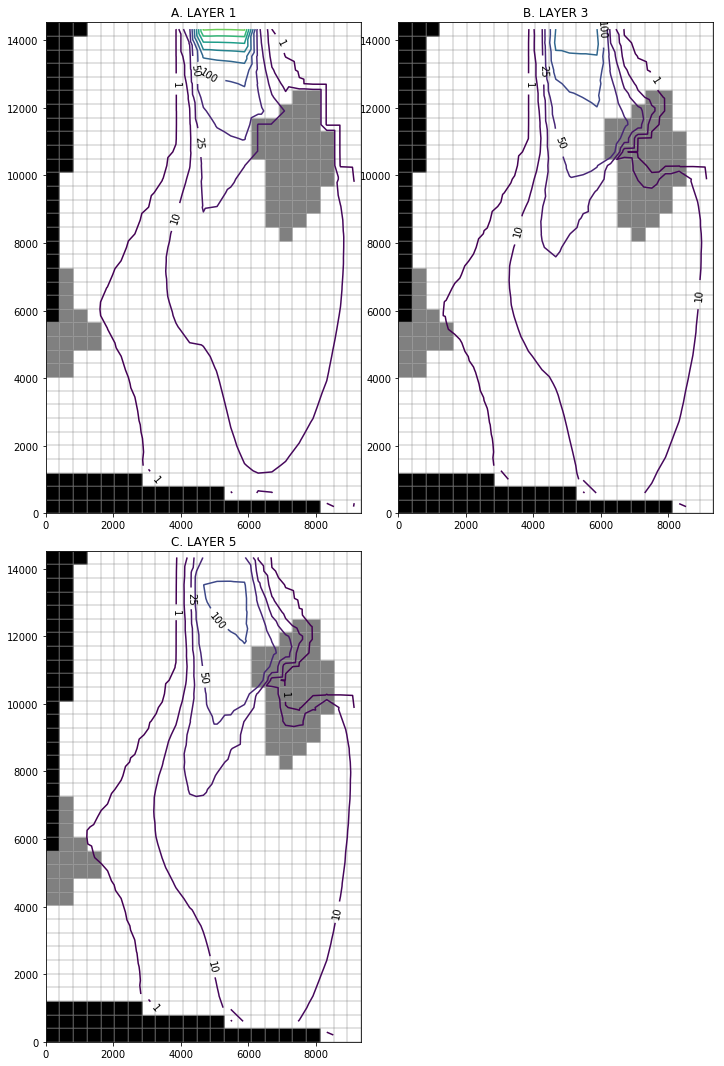

In [490]:
levels = [1, 10, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450]
fig = plt.figure(figsize=(10, 15))
galpha = 0.3

ax = plt.subplot(2, 2, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=0)
pmv.plot_grid(alpha=galpha)
#cb = pmv.plot_array(conc, masked_values=[1.e30], cmap='jet')
cs = pmv.contour_array(concclak, masked_values=[1.e30], levels=levels)
plot_lakes(ax)
ax.set_title('A. LAYER 1')
plt.clabel(cs, [1, 10, 25, 50, 100, 450], fmt='%1.0f', colors='k')

ax = plt.subplot(2, 2, 2, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
pmv.plot_grid(alpha=galpha)
#cb = pmv.plot_array(conc, masked_values=[1.e30], cmap='jet')
cs = pmv.contour_array(concclak, masked_values=[1.e30], levels=levels)
plot_lakes(ax)
ax.set_title('B. LAYER 3')
plt.clabel(cs, [1, 10, 25, 50, 100, 450], fmt='%1.0f', colors='k')

ax = plt.subplot(2, 2, 3, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=4)
pmv.plot_grid(alpha=galpha)
#cb = pmv.plot_array(conc, masked_values=[1.e30], cmap='jet')
cs = pmv.contour_array(concclak, masked_values=[1.e30], levels=levels)
plot_lakes(ax)
plt.tight_layout()
ax.set_title('C. LAYER 5')
plt.clabel(cs, [1, 10, 25, 50, 100, 150], fmt='%1.0f', colors='k')

(0, 35)

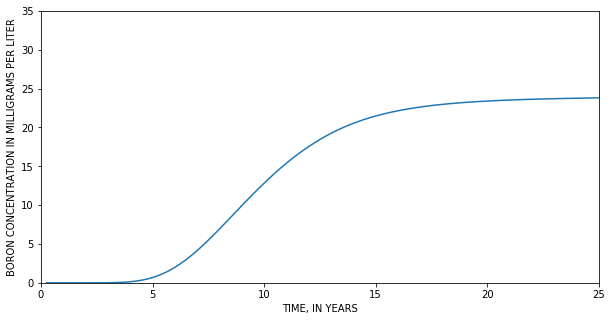

In [491]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
t = result_dict['claktimes']
c = result_dict['clak'][:, 0, 0, 0]
ax.plot(np.array(t)/365., c)
ax.set_ylabel('BORON CONCENTRATION IN MILLIGRAMS PER LITER')
ax.set_xlabel('TIME, IN YEARS')
ax.set_xlim(0, 25)
ax.set_ylim(0, 35)

In [477]:
stage

array([[[45.99936003, 37.43320893]]])

# MODFLOW-2005 Version

In [492]:
def get_mf2005_model(ws, name, nlay=8, nrow=36, ncol=23,
                     constant_concentration=False, general_head_boundary=False,
                     ctimes=None, cidx=None, sptimes=None, verbosity_level=1):
    
    # model units are in cm/min

    lx = 23 * 4.05665E02
    ly = 36 * 4.03717E02

    delr = lx / ncol
    delc = ly / nrow
    top = 100.
    botm = []
    tp = top * np.ones((nrow, ncol), dtype=np.float)
    for k in range(0, nlay):
        dz = 15.
        if k == 0:
            dz = getdz0()
        bt = tp - dz
        botm.append(tp - dz)
        tp = bt
        
    perlen = [25 * 365.] # time is in days
    nper = len(perlen)
    nstp = [1]
    tsmult = [1.]
    steady = True
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

    nouter, ninner = 10000, 10
    hclose, rclose, relax = 1e-4, 1., 0.97

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    fname = './data/gwt_lak_ibd.dat'
    ibound0 = np.loadtxt(fname)

    hk = 250. # ft/d
    vk = 125.
    recharge = 4.79e-3
    lakarr0 = np.where(ibound0 > 1, ibound0, 0)
    lakarr0 = np.where(lakarr0 > 1, lakarr0 - 1, 0)
    lakarr = np.zeros((nlay, nrow, ncol), dtype=np.int)
    lakarr[0] = lakarr0
    ibound0 = np.where(ibound0 > 1, 0, ibound0)

    gwf = flopy.modflow.Modflow(modelname=gwfname, exe_name='mf2005', model_ws=ws)
    dis = flopy.modflow.ModflowDis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, 
                                   delr=delr, delc=delc, top=top, botm=botm)
    bas = flopy.modflow.ModflowBas(gwf, hnoflo=1.e30, ichflg=True,
                                   ibound=nlay*[ibound0], 
                                   strt=nlay*[getstrt()])
    lpf = flopy.modflow.ModflowLpf(gwf, constantcv=True,
                                   hk=hk, vka=vk, laytyp=[1, 1] + 6 * [0])
    rch = flopy.modflow.ModflowRch(gwf, rech=recharge)
    pcg = flopy.modflow.ModflowPcg(gwf, mxiter=nouter, iter1=ninner, hclose=hclose, rclose=rclose)
    oc = flopy.modflow.ModflowOc(gwf, compact=True,
                                 stress_period_data={(0, 0): ['save head', 'print head', 'save budget']})
    oc.reset_budgetunit()

    lak = flopy.modflow.ModflowLak(gwf, 
                                   nlakes=2,
                                   nssitr=1000,
                                   sscncr=hclose,
                                   stages=[44.7, 35.2],
                                   lakarr=lakarr,
                                   bdlknc=10.,
                                   flux_data={0:[[0., 0., 0., 0.], [0., 0., 0., 0.]]})
    
    gwf.write_input()
    gwf.run_model()

      
    result_dict = {}
    
    result_dict['sim'] = sim
    result_dict['gwf'] = gwf
    
    fname = gwfname + '.hds'
    fname = os.path.join(ws, fname)
    hobj = flopy.utils.HeadFile(fname)
    head = hobj.get_data()
    hobj.file.close()
    result_dict['head'] = head

    return result_dict



    fname = gwfname + '.lak.bin'
    fname = os.path.join(ws, fname)
    hobj = flopy.utils.HeadFile(fname, precision='double', text='stage')
    stage = hobj.get_data()
    hobj.file.close()
    result_dict['stage'] = stage



    
    result_dict['gwt'] = gwt

    fname = gwtname + '.ucn'
    fname = os.path.join(ws, fname)
    cobj = flopy.utils.HeadFile(fname, precision='double', text='concentration')
    conc = cobj.get_data()
    cobj.file.close()
    result_dict['conc'] = conc

    fname = gwtname + '.lkt.bin'
    fname = os.path.join(ws, fname)
    cobj = flopy.utils.HeadFile(fname, precision='double', text='concentration')
    conc = cobj.get_alldata()
    times = cobj.get_times()
    cobj.file.close()
    result_dict['clak'] = conc
    result_dict['claktimes'] = times
    
    return result_dict

ws = './temp/pxx_gwt_lak_mf2005'
name = 'gwtlak'
result_dict = get_mf2005_model(ws, name)

FloPy is using the following  executable to run the model: /Users/langevin/langevin/bin/mac/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: gwf_gwtlak.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/08/13 15:51:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/08/13 15:51:49
 Elapsed run time:  0.091 Seconds

  Normal termination of simulation


<a list of 5 text.Text objects>

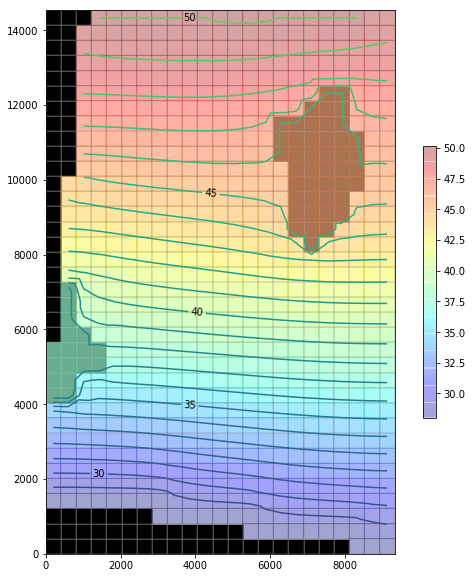

In [483]:
head = result_dict['head']
headstage = head.copy()

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=0)
pmv.plot_grid(alpha=0.3)
cb = pmv.plot_array(headstage, masked_values=[1.e30], cmap='jet', alpha=0.2)
cs = pmv.contour_array(headstage, masked_values=[1.e30], levels=np.arange(20, 60))
fname = './data/gwt_lak_ibd.dat'
ibd = np.loadtxt(fname)
plot_lakes(ax)
plt.colorbar(cb, shrink=0.5)
plt.clabel(cs, [30, 35, 40, 45, 50], fmt='%1.0f', colors='k')